In [112]:
%pylab inline
%load_ext autoreload
%autoreload 2
from tqdm import trange
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/brucewayne/.pyenv/versions/3.8.5/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['step']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [38]:
# load data
import numpy as np
import gzip
parse = lambda file: np.frombuffer(gzip.open(file).read(), dtype=np.uint8).copy()
X_train = parse("data/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
X_test = parse("data/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))

In [125]:
import torch 
import torch.nn as nn

class LinearGen(nn.Module):
  def __init__(self):
    super(LinearGen, self).__init__()
    # batchnorm after relu causes mode collapse mmm
    self.layers = nn.Sequential(
      nn.Linear(128, 256),
      nn.BatchNorm1d(256),
      nn.LeakyReLU(0.2), 
      nn.Linear(256, 512),
      nn.BatchNorm1d(512),
      nn.LeakyReLU(0.2), 
      nn.Linear(512, 1024),
      nn.LeakyReLU(0.2), 
      nn.Linear(1024, 784),
      nn.Tanh()
    )
    
  def forward(self, x):
    x = self.layers(x)
    return x

class LinearDisc(nn.Module):
  def __init__(self):
    super(LinearDisc, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(784, 1024),
      nn.LeakyReLU(0.2), 
      nn.Dropout(0.3),
      nn.Linear(1024, 512),
      nn.LeakyReLU(0.2), 
      nn.Dropout(0.3),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2), 
      nn.Dropout(0.3),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )
  
  def forward(self, x):
    x = self.layers(x)
    return x.view(-1)

In [116]:
BS = 512 
k = 1 
epochs = 300
n_batches = int(X_train.shape[0]/BS)

In [133]:
def generate_batch(): 
  samp = np.random.randint(0, X_train.shape[0], size=(BS))
  image = X_train[samp].reshape(-1, 28*28).astype(np.float32)/255.
  return torch.tensor(image).to(device)

loss_function = nn.BCELoss()
def train_discriminator(optimizer, data_real, data_fake): 
  optimizer.zero_grad()

  output_real = discriminator(data_real)
  y = torch.ones(BS).to(device)
  loss_real = loss_function(output_real, y)
  
  output_fake = discriminator(data_fake.detach())
  y = torch.zeros(BS).to(device)
  loss_fake = loss_function(output_fake, y)

  loss_real.backward()
  loss_fake.backward()
  optimizer.step()
  return loss_real.item() + loss_fake.item()

def train_generator(optimizer, data_fake):
  optimizer.zero_grad()
  out = discriminator(data_fake)
  y = torch.ones(BS).to(device)
  loss = loss_function(out, y)
  loss.backward()
  optimizer.step()
  return loss.item()

  0%|          | 0/300 [00:00<?, ?it/s]

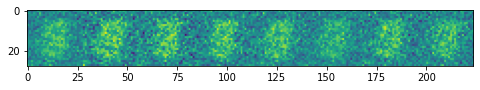

epoch loss_g 1.75 loss_d 0.93:   8%|▊         | 25/300 [00:30<05:37,  1.23s/it]

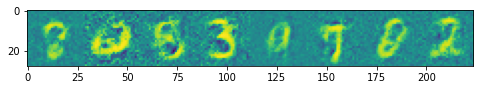

epoch loss_g 2.52 loss_d 0.65:  17%|█▋        | 50/300 [01:01<05:11,  1.25s/it]

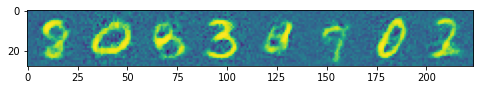

epoch loss_g 2.77 loss_d 0.58:  25%|██▌       | 75/300 [01:32<04:39,  1.24s/it]

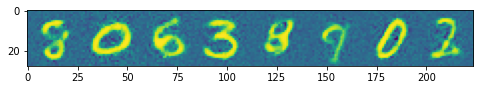

epoch loss_g 2.88 loss_d 0.55:  33%|███▎      | 100/300 [02:03<04:06,  1.23s/it]

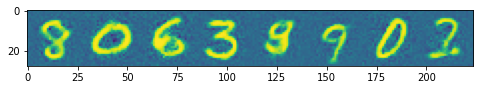

epoch loss_g 2.90 loss_d 0.52:  42%|████▏     | 125/300 [02:34<03:35,  1.23s/it]

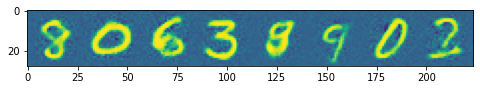

epoch loss_g 2.98 loss_d 0.50:  50%|█████     | 150/300 [03:05<03:07,  1.25s/it]

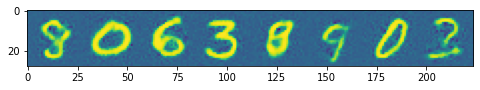

epoch loss_g 3.00 loss_d 0.48:  58%|█████▊    | 175/300 [03:36<02:33,  1.23s/it]

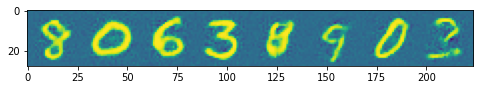

epoch loss_g 3.04 loss_d 0.46:  67%|██████▋   | 200/300 [04:07<02:03,  1.23s/it]

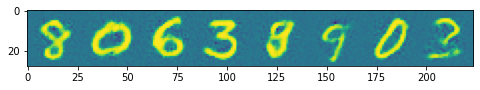

epoch loss_g 3.72 loss_d 0.36:  75%|███████▌  | 225/300 [04:38<01:32,  1.24s/it]

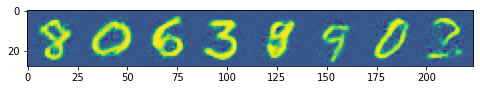

epoch loss_g 5.12 loss_d 0.26:  83%|████████▎ | 250/300 [05:09<01:02,  1.24s/it]

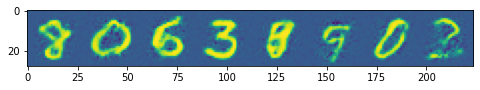

epoch loss_g 5.10 loss_d 0.50:  92%|█████████▏| 275/300 [05:40<00:30,  1.23s/it]

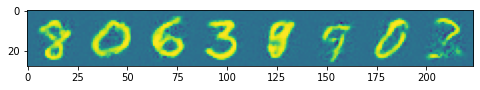

epoch loss_g 6.52 loss_d 0.15: 100%|██████████| 300/300 [06:11<00:00,  1.24s/it]


In [134]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = LinearGen().to(device)
discriminator = LinearDisc().to(device)
optim_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
ds_noise = torch.randn(8, 128).to(device)

# train
losses_g, losses_d = [], []
for epoch in (t := trange(epochs)):
  epoch_loss_g = 0
  epoch_loss_d = 0
  for i in range(n_batches):
    data_real = generate_batch()
    for step in range(k):
      noise = torch.tensor(np.random.rand(BS, 128)).float().to(device)
      data_fake = generator(noise)
      loss_d = train_discriminator(optim_d, data_real, data_fake)
      epoch_loss_d += loss_d
      
    #noise = torch.tensor(np.random.randn(BS, 128)).float()
    #data_fake = generator(noise)
    loss_g = train_generator(optim_g, data_fake)
    epoch_loss_g += loss_g

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    
  if epoch%25 == 0:
    fake_images = generator(ds_noise).detach()
    fake_images = ((fake_images.reshape(-1, 28, 28)+1)/2).cpu().numpy()
    fake_images = np.concatenate(fake_images, axis=1)
    figure(figsize=(8,8))
    imshow(fake_images)
    show()
  
  epoch_loss_g /= n_batches
  epoch_loss_d /= n_batches
  t.set_description("epoch loss_g %.2f loss_d %.2f" % (epoch_loss_g, epoch_loss_d))

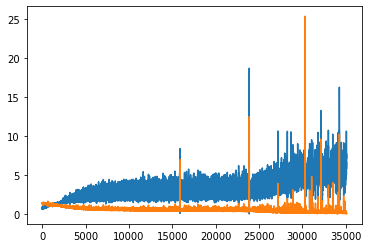

In [136]:
plot(losses_g, label="generator loss")
plot(losses_d, label="discriminator loss")
# gets worse after ~25000 steps

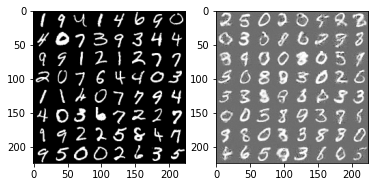

In [154]:
# comparison grid
samp = np.random.randint(0, X_test.shape[0], size=64)
batch = X_test[samp]
real = np.concatenate(batch.reshape(8, 8*28, 28), axis=1)
fake = generator(torch.randn(64, 128).to(device)).cpu().detach().numpy()
fake = np.concatenate(fake.reshape(8, 8*28, 28), axis=1)
fig, (ax1, ax2) = subplots(1, 2)
ax1.imshow(real, cmap='gray')
ax2.imshow(fake, cmap='gray')
